> [原文地址](https://nbviewer.jupyter.org/github/leesper/become-data-analyst/blob/master/P0_BayAreaBikeShareAnalysis/Bay_Area_Bike_Share_Analysis.ipynb)

这份数据有点类似摩拜单车骑行数据, 数据文件是由湾区这家做共享单车的公司分享出来的，可以在[这个目录下](https://github.com/udacity/data-analyst/tree/master/projects/bike_sharing) 找到数据文件, 主要是下面3个数据

* 行程数据（展示系统中每个行程的信息）（*_trip_data.csv)
* 系统中车站的信息（*_station_data.csv）
* 系统中每个城市的每日天气数据（*_weather_data.csv）



In [2]:
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [3]:
# 导出一份样本数据，用来调试程序
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # 设置 CSV 读写对象
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # 从 in-file 向 out-file 写入行，直到遇到特定日期
    while True:
        datarow = next(in_reader)
        # 行程开始日期在第三列，为 m/d/yyyy HH:MM  格式
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

In [4]:
sample_data = pd.read_csv('201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


字段信息：行程持续时间，开始时间，开始的位置，？，结束时间， 结束位置， ？， 单车ID， 订阅类型，年费用户的编码

In [8]:
# 显示车站文档的前几行
station_info = pd.read_csv("201402_station_data.csv")
display(station_info.head())

# 车站到城市的映射
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # 设置 csv 读取对象 - 注意，我们使用的是 DictReader，他会将
            # 文档第一行作为表头，即每一行的字典键值
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [9]:
def summarise_data(trip_in, station_data, trip_out):
    """    
    输出一个新文件
    """
    # 生成车站字典 - 城市映射
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # 设置 csv 写入对象       
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # 设置 csv 读取对象
                trip_reader = csv.DictReader(f_in)

                # 从每行数据中收集和处理
                for row in trip_reader:
                    new_point = {}
                    
                    # 转换持续时间单位：从秒到分
                    ### 问题 3a: 在下方加入数学运算   ###
                    ### 将持续时间从秒转换为分       ###
                    new_point['duration'] = float(row['Duration'])/60.0
                    
                    # 将 datestrings 存储进不同的列 
                    ### 问题 3b: 在下方空格中填入以生成 ###
                    ### 预期的时间值                 ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # 基于起始城市重新映射起始站点
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # 定阅者的两个不同列名称
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # 导出处理完成的信息
                    trip_writer.writerow(new_point)

In [10]:
# 运行我们上面写的程序来处理数据
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# 载入数据文件并打印开头几行
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# 通过统计匹配不同时间特征的数据点来验证 dataframe 
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


All counts are as expected!


In [11]:
trip_data = pd.read_csv('201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

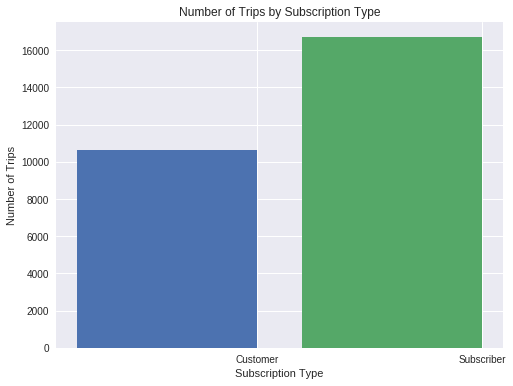

In [12]:
usage_plot(trip_data, 'subscription_type')

看起来在第一个月，订购者的行程比客户的行程多大约 50%。现在我们来尝试一个不同的变量。来看看行程的持续时间状况如何？

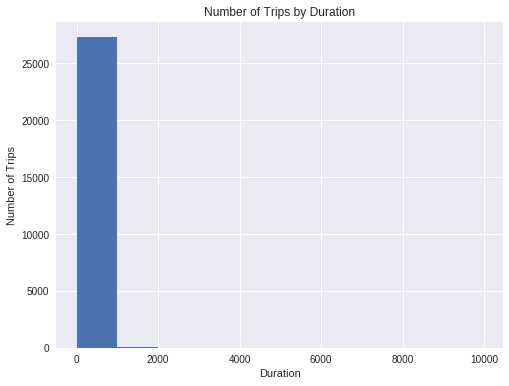

In [13]:
usage_plot(trip_data, 'duration')

这个图看到一些脏数据，就是类似忘了关锁之类的。

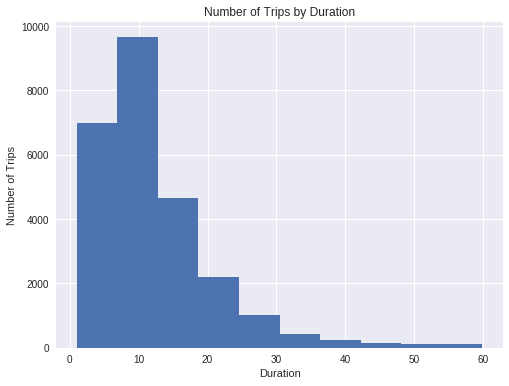

In [14]:
usage_plot(trip_data, 'duration', ['duration < 60'])

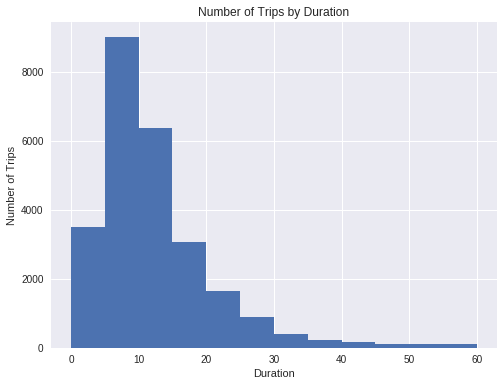

In [15]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

5分钟到10分钟的出行次数最多